<a id="section1"></a>
# 1. Importing necessary libraries


In [5]:
import random
from scipy.signal import butter, lfilter
import numpy as np
import pandas as pd
import scipy.io as spio
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [6]:
data_path='/content/drive/MyDrive/Coursework_C/'

In [7]:
# read submition data file
mat = spio.loadmat(data_path + 'submission.mat', squeeze_me=True)
submission = mat['d']

In [8]:
%pylab inline
from matplotlib import style
style.use('https://raw.githubusercontent.com/JoseGuzman/minibrain/master/minibrain/paper.mplstyle')

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['mat', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Filter submission one way

In [50]:
import scipy.signal as ss

In [82]:
def filter_data_1(data, low=30, high=6000, sf=25000, order=4):
     nyq = sf/2   # Set bands
     low = low/nyq
     high = high/nyq # Calculate coefficients
     b, a = butter(order, [low, high], btype='band')   # Filter signal
     filtered_data = ss.filtfilt(b, a, data)
     return filtered_data

In [83]:
submission_filtered_1=filter_data_1(submission)

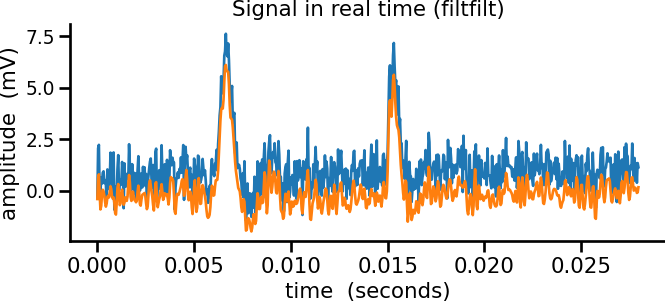

In [85]:
#plot filtered vs raw samples
plt.plot(np.array(range(submission[481800:482500].size))/25000, submission[481800:482500])
plt.title('Signal in real time (filtfilt)')
plt.xlabel('time  (seconds)')
plt.ylabel('amplitude  (mV)')
plt.plot(np.array(range(submission_filtered_1[481800:482500].size))/25000, submission_filtered_1[481800:482500])
plt.show()

# Filter submission another way

In [73]:
def filter_data(data, low=30, high=6000, sf=25000, order=4):
     nyq = sf/2   # Set bands
     low = low/nyq
     high = high/nyq # Calculate coefficients
     b, a = butter(order, [low, high], btype='band')   # Filter signal
     filtered_data = lfilter(b, a, data)
     return filtered_data


In [74]:
submission_filtered=filter_data(submission)

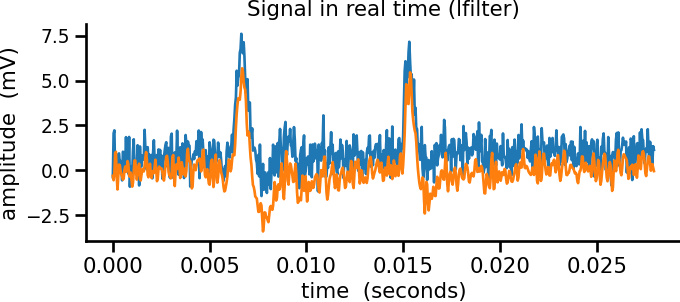

In [86]:
plt.plot(np.array(range(submission[481800:482500].size))/25000, submission[481800:482500])
plt.title('Signal in real time (lfilter)')
plt.xlabel('time  (seconds)')
plt.ylabel('amplitude  (mV)')
plt.plot(np.array(range(submission_filtered[481800:482500].size))/25000, submission_filtered[481800:482500])
plt.show()

# Spike sorting

Now that we separated the high frequency spike band from the noisy low frequency band we can extract the individual spikes. For this we will write a simple function that does the following:

    1. Find data points in the signal that are above a certain threshold
    2. Define a window around these events and “cut them out”
    3. Align them to their peak amplitude

Additionally we will also define an upper threshold. Data points above this threshold will be rejected as they are likely high frequency artifacts. Such artifacts may arise through movements of the patient or might reflect electrical events like switching on or off a light bulb in the room.

Arguements: 
1.   the filtered data
2.   the number of samples or window which should be extracted from the signal 
3. the threshold factor (mean(signal)*tf) 
4. an offset expressed in number of samples which shifts the maximum peak from the center 
5. the upper threshold which excludes data points above this limit to avoid extracting artifacts.

In [166]:
def get_spikes(data, spike_window=20, tf=5, offset=0, max_thresh=15):
    # Calculate threshold based on data median
    thresh = np.median(np.abs(data))*tf
    # Find positions wherere the threshold is crossed
    pos = np.where(data > thresh)[0] 
    pos = pos[pos > spike_window]
    # Extract potential spikes and align them to the maximum
    spike_samp = []
    wave_form = np.empty([1, spike_window*2])
    for i in pos:
        if i < data.shape[0] - (spike_window+1):
            # Data from position where threshold is crossed to end of window
            tmp_waveform = data[i:i+spike_window*2]
            # Check if data in window is below upper threshold (artifact rejection)
            if np.max(tmp_waveform) < max_thresh:
                # Find sample with maximum data point in window
                tmp_samp = np.argmax(tmp_waveform) +i
                # Re-center window on maximum sample and shift it by offset
                tmp_waveform = data[tmp_samp-(spike_window-offset):tmp_samp+(spike_window+offset)]
                # Append data
                spike_samp = np.append(spike_samp, tmp_samp)
                wave_form = np.append(wave_form, tmp_waveform.reshape(1, spike_window*2), axis=0)
    # Remove duplicates
    ind = np.where(np.diff(spike_samp) > 1)[0]
    spike_samp = spike_samp[ind]
    wave_form = wave_form[ind]
    return spike_samp, wave_form

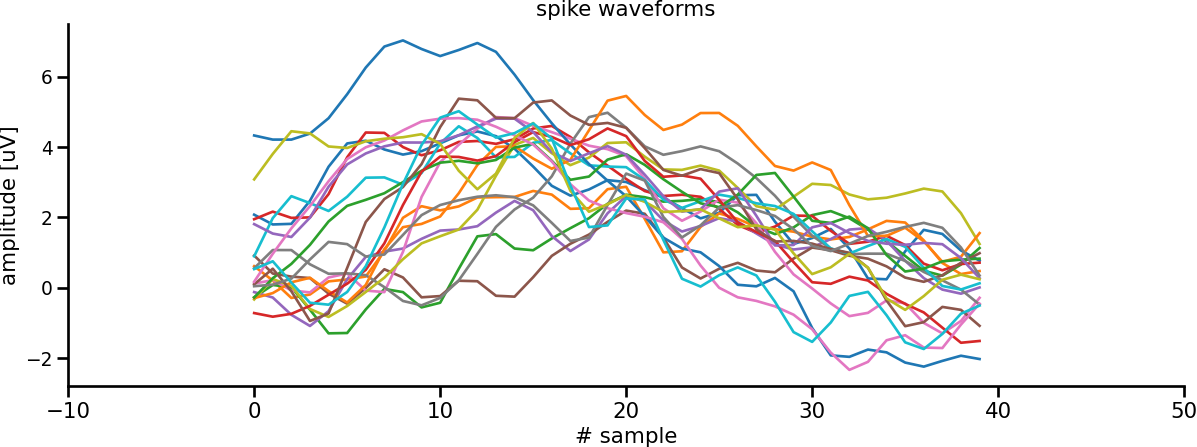

Detected number of spikes =  (6669,)


In [167]:
spike_samp, wave_form = get_spikes(submission_filtered_1, spike_window=20, tf=5)
spike_samp=spike_samp.astype(int)
np.random.seed(42)
fig, ax = plt.subplots(figsize=(15, 5))

for i in range(20):
    spike = np.random.randint(0, wave_form.shape[0])
    ax.plot(wave_form[spike, :])

ax.set_xlim([-10, 50])
ax.set_xlabel('# sample')
ax.set_ylabel('amplitude [uV]')
ax.set_title('spike waveforms')
plt.show()
print("Detected number of spikes = ",spike_samp.shape)

<a id="section2"></a>
# 2. Loading the dataset


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
data_path='/content/drive/MyDrive/Coursework_C/'
mat = spio.loadmat(data_path + 'training.mat', squeeze_me=True)
d = mat['d']
Index = mat['Index']
Class = mat['Class']
Index_sorted=sorted(Index)

In [10]:
# define some custom colors for visualization
mycolors = {1:     '#FFA500', # orange
          2:       '#4169E1', # royalblue
          3:  '#FF4500', # orange red
          4:  '#9400D3', #darkviolet
          5:     '#32CD32', # limegreen 
    }
mcolours=[]
for c in Class:
  mcolours.append(mycolors[c])


In [11]:
#arrange Index (starts of activations) and Class in a list of tuples
number_of_activations=len(Index)
keys=[]
for j in range(number_of_activations):
  keys.append((Index[j],Class[j]))
waveforms=[]
for k in keys:
  waveforms.append(d[k[0]:k[0]+40])


<a id="section3"></a>
# 3. Visualize waveforms

We add a column *color* in our Pandas DataFrame that includes the corresponding tissue color in RBG.

In [12]:
def plot_waveform(index, ax = None):
    if ax is None:
        myax = plt.gca()
    else:
        myax = ax
    
    
    myax.plot(waveforms[index], color=mycolors[keys[index][1]])
    myax.text(x = 5, y= 0.75, s=keys[index][1])
    
    return myax


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


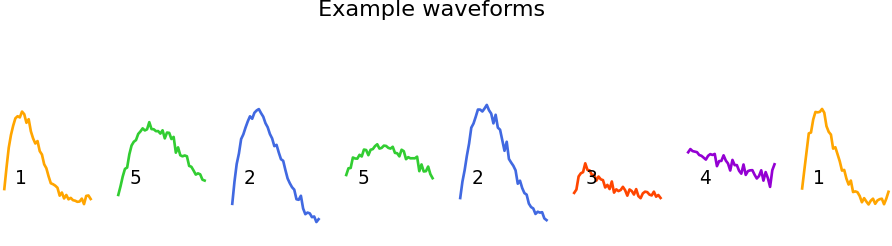

In [13]:
fig, ax = plt.subplots(1,8, figsize=(12,3))
fig.suptitle('Example waveforms')

ax[0] = plot_waveform(index = 66,  ax = ax[0])
ax[1] = plot_waveform(index = 2, ax = ax[1])
ax[2] = plot_waveform(index = 3, ax = ax[2])
ax[3] = plot_waveform(index = 4, ax = ax[3])
ax[4] = plot_waveform(index = 5, ax = ax[4])
ax[5] = plot_waveform(index = 6,  ax = ax[5])
ax[6] = plot_waveform(index = 7,  ax = ax[6])
ax[7] = plot_waveform(index = 8,  ax = ax[7])


for myax in ax:
    myax.set_ylim(-3,10)
    myax.grid()
    myax.axis('off')
#plt.savefig('spikes.png', dpi = 300)

<a id="section4.1"></a>
## 4.1 Principal Components Analysis (PCA)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


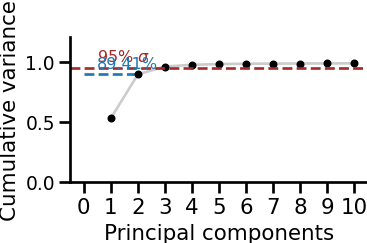

In [14]:
from sklearn.decomposition import PCA
import numpy as np

N_components = 10
mypca = PCA(n_components=N_components)
PC = mypca.fit(waveforms)

fig, ax = plt.subplots(figsize=(4,2))
x = np.arange(1, N_components+1, step=1)
y = np.cumsum(mypca.explained_variance_ratio_)


plt.plot(x, y, '-', color='gray', alpha = 0.4)
plt.plot(x, y, 'o', color='k')

plt.ylim(0.0,1.2)

plt.xlabel('Principal components')
plt.xticks(np.arange(0, 11, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance')

plt.axhline(y = 0.95, color = 'brown', linestyle = '--')
plt.hlines(y = y[1], xmin = 0, xmax = 2, color = 'C0', linestyle = '--')
plt.text(0.5, 1, '95% $\sigma$', color = 'brown', fontsize=12)
plt.text(0.5, y[1]+0.05, s=f'{y[1]*100:1.2f}%', color = 'C0', fontsize= 12)
plt.show()

Let's plot the first two projections for visualization

In [15]:
mypca = PCA(n_components=2)
PC = mypca.fit_transform(waveforms)
wave=[]
wave=pd.DataFrame(wave)
wave['nclass']=Class
wave['waveform']=waveforms
wave['PC1'] = PC[:,0]
wave['PC2'] = PC[:,1]
wave['color']=mcolours
var1, var2 = mypca.explained_variance_ratio_*100 # variance in percentage
print('Explained variation by the two first principal components: {:2.2f}%, {:2.2f}%'.format(var1, var2))

Explained variation by the two first principal components: 53.10%, 36.30%


In [16]:
wave.head(10)

,nclass,waveform,PC1,PC2,color
0,4,"[-0.2358052916582669, 0.2571856974207856, 0.58...",-1.411641,4.632647,#9400D3
1,2,"[0.22386874778176574, 1.4571621254065508, 2.26...",5.546002,-5.856092,#4169E1
2,5,"[0.05408806753804045, 0.5666500773703529, 1.15...",5.170246,4.897705,#32CD32
3,2,"[-0.47706182893929366, 0.8482876253193449, 1.9...",3.010078,-5.314534,#4169E1
4,5,"[1.2449080424078343, 1.644990632747059, 1.6652...",1.106332,5.360664,#32CD32
5,2,"[-0.13203570581471785, 0.8496268928563954, 1.5...",4.219461,-5.181513,#4169E1
6,3,"[0.17627921647124878, 0.3754439594426137, 1.15...",-9.757019,1.498696,#FF4500
7,4,"[2.6035021376849263, 2.7942489948901903, 2.674...",-2.469130,2.983616,#9400D3
8,1,"[0.44168110932635307, 1.5490178251964744, 2.63...",-1.424238,-6.129872,#FFA500
9,3,"[-0.37572184246034945, 0.3057454124375895, 1.0...",-11.063819,1.369011,#FF4500


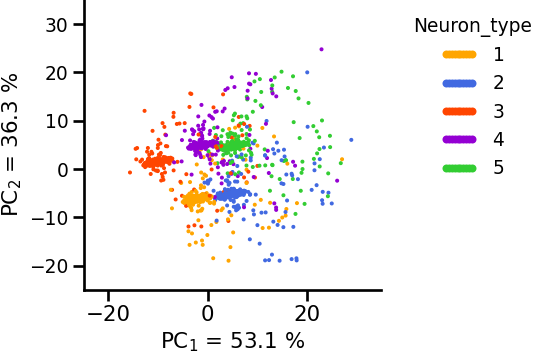

In [17]:
# visualize
fig, ax = plt.subplots(1,1, figsize=(4,4))

ax.scatter(x = wave.PC1, y = wave.PC2, s=4, c=wave.color)
ax.set_xlabel(f'PC$_1$ = {var1:2.1f} %');
ax.set_ylabel(f'PC$_2$ = {var2:2.1f} %');
ax.set_xlim(-25,35), ax.set_ylim(-25,35)

markers = [plt.Line2D([],[], color= i, marker = 'o', linestyle = '') for i in mycolors.values()]

ax.legend(markers, mycolors.keys(), numpoints = 10,  title = 'Neuron_type', bbox_to_anchor=(1.05, 1), loc='upper left')

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


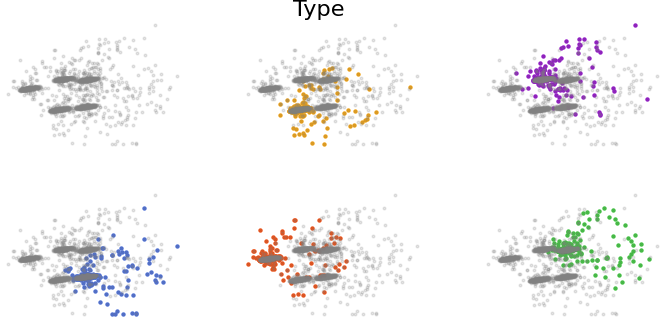

In [18]:
# visualize
fig, ax = plt.subplots(2,3, figsize=(8,4), sharex=True, sharey = True)
fig.tight_layout()
fig.suptitle('Type')

def plot_ax(organoidtype, loc=(0,0)):
    """
    Auxiliary plot function to return subplot axis
    of the two first PCA projections of a tissue.
    
    Argument:
    organoidtype:  (str)
        The type of tissue we want to plot
    
    loc: (list)
        The x,y location of the axis object in the subplot
    """
    x = wave[wave.nclass==organoidtype].PC1
    y = wave[wave.nclass==organoidtype].PC2
    
    i,j = loc
    return ax[i,j].scatter(x, y, color=mycolors[organoidtype], s = 5)


plot_ax(1, loc=(0,1))
plot_ax(2, loc=(1,0))

plot_ax(3, loc=(1,1))
plot_ax(4, loc=(0,2))

plot_ax(5, loc=(1,2))




for myax in ax.flatten():
    myax.scatter(x = wave.PC1, y = wave.PC2, c='gray', s = 4, alpha = 0.2)
    #myax.set_xlabel(f'PC$_1$ = {var1:2.1f} %');
    #myax.set_ylabel(f'PC$_2$ = {var2:2.1f} %');
    myax.legend(loc='upper center', fontsize=10, frameon=False)
    myax.axis('off')

<a id="section4.2"></a>
## 4.2 K-means clustering

We now use the first two-principal components to perform an umbiassed K-means clustering. We will calculate the minimal number of clusters we need to perform an umbiassed classification.

In [19]:
from sklearn.cluster import KMeans



# Cluster calculation
To determine the optimal number of clusters, we need to compute the cluster after which the distortion/inertia start decreasing linearly.  The distortion or inertia of a K-Means clustering result is the sum of squared differences between an observation and it's corresponding centroid.

**Inertia**: is the sum of squared errors. Thus, the inertia is the sum of squared euclidian distances for each point to its closed centroid.
<math>
$$ \sum_{i = 1}^{n}{d(x_i, c_k)^2} ,$$
</math>

where $n$ is the number of points,  $c_k$ is the k-centroid, and $d()$ is the euclidian distance.

To detect the minimal number of clusters, we can compute the second derivative of the inertia.



In [25]:
inertia = list() # sum of squared error

for k in range(1,21):
    km = KMeans(n_clusters=k, init='k-means++', random_state = 42)
    km = km.fit(PC)
    inertia.append(km.inertia_)

Number of k-clusters:3


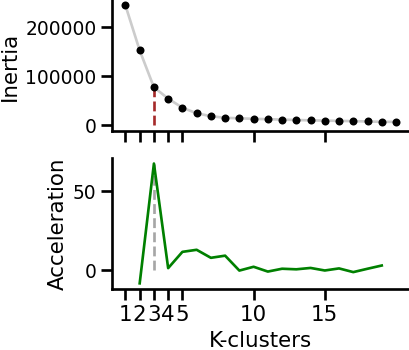

In [26]:
idx = np.arange(1, len(inertia) + 1)

fig, ax = plt.subplots(2, 1, figsize=(4,4), sharex=True)

ax[0].plot(idx, inertia, '-', color='gray', alpha = 0.4)
ax[0].plot(idx, inertia, 'ko', ms=6)
ax[0].set_xticks([1,2,3,4,5, 10, 15])

ax[0].set_ylabel('Inertia');

acceleration = np.diff(np.sqrt(inertia), 2)  # 2nd derivative of the distances

ax[1].plot(idx[:-2] + 1, acceleration, 'g-', ms=8)
ax[1].set_ylabel('Acceleration')
ax[1].set_xlabel('K-clusters')
#ax[1].set_yticks(np.arange(-1,7))

# calculate clusters

k = acceleration.argmax() + 2  # if idx 0 is the max of this we want 2 clusters
ax[0].vlines(x = k, ymin = 0, ymax = inertia[k-1], color='brown', linestyle='--')
ax[1].vlines(x = k, ymin = 0, ymax = acceleration[k-2], color='gray', linestyle='--', alpha=0.7)

print(f'Number of k-clusters:{k}')


In [27]:
# define colors according to the cluster label
myKmeans = KMeans(n_clusters=5, init='k-means++', random_state = 42)
myKmeans.fit(PC)
kcolors = pd.DataFrame(myKmeans.labels_, columns=['Ktype'])

kcolors['color'] = kcolors['Ktype'].map({1: 'green', 0:'orange', 2:'purple',3:'blue',4:'red'})


We use scipy.spatial.distance.cdist compute distance between each pair of collections of inputs.

In [28]:
from scipy.spatial.distance import cdist

def plot_radii(mykmeans, X, ax = None):
    """
    Plots k-centroids from a kmeans model
    
    Arguments
    ---------
    kmeans (Kmeans object)
        (sklearn.sklearn.cluster.Kmeans model)
    
    X (2D-Numpy array)
        The observations ith the observations)
    
    ax (an axis object)
    """
    # plot the input data
    ax = ax or plt.gca()
    
    labels = mykmeans.labels_ # read labels

    centers = mykmeans.cluster_centers_ # centroids
    radii = [cdist(X[labels == i], [center]).max() for i, center in enumerate(centers)]
    
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='gray', lw=1, alpha=0.05, zorder=1))

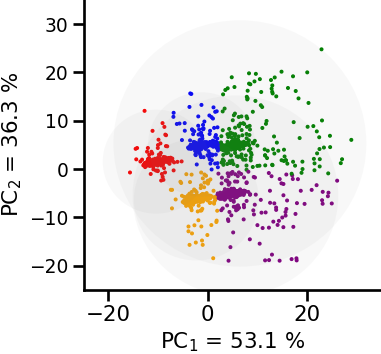

In [29]:
fig, ax = plt.subplots(1,1, figsize=(4,4))

ax.scatter(x = wave.PC1, y = wave.PC2, s=4, c=kcolors.color)
ax.set_xlabel(f'PC$_1$ = {var1:2.1f} %');
ax.set_ylabel(f'PC$_2$ = {var2:2.1f} %');
ax.set_xlim(-25,35), ax.set_ylim(-25,35)
plot_radii(mykmeans = myKmeans, X = PC, ax = ax)

We now calculate the percentage of waveforms in every cluster.

In [30]:
# calculate percentages (just for fun with different NumPY methods :P)
prop_0 = 100 * np.count_nonzero(myKmeans.labels_==0) / len (myKmeans.labels_)
prop_1 = 100 * np.count_nonzero(myKmeans.labels_==1) / len (myKmeans.labels_)
prop_2 = 100 * np.sum(myKmeans.labels_==2)           /len(myKmeans.labels_)


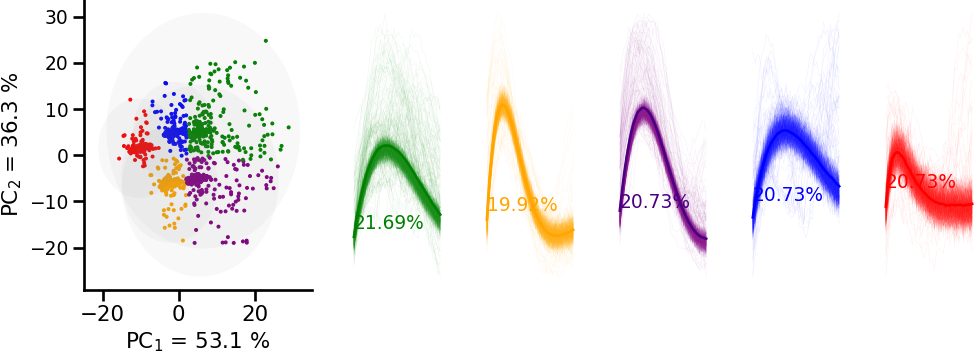

In [31]:
# visualize

grid = plt.GridSpec(1, 7, wspace=0.4, hspace=0.4)

fig = plt.figure(figsize=(12, 4))
pca_plot = fig.add_subplot(grid[0, 0:2])

pca_plot.scatter(x = wave.PC1, y = wave.PC2, s=4, c=kcolors.color)
pca_plot.set_xlabel(f'PC$_1$ = {var1:2.1f} %');
pca_plot.set_ylabel(f'PC$_2$ = {var2:2.1f} %');
pca_plot.set_xlim(-25,35), ax.set_ylim(-25,35)
plot_radii(myKmeans, PC, ax = pca_plot)

wave0 = fig.add_subplot(grid[0, 2])
w = list()
idx = np.where(kcolors.Ktype==1)
for i in idx[0]:
    mytrace = waveforms[i]
    wave0.plot(mytrace, lw=0.5, color='green', alpha=0.05)
    w.append(mytrace)
wave0.plot(np.mean(w, axis=0), color='green')
wave0.text(x = 0, y = .5, s = f'{prop_1:2.2f}%', color='green')


wave1 = fig.add_subplot(grid[0, 3])
w = list()
idx = np.where(kcolors.Ktype==0)
for i in idx[0]:
    mytrace = waveforms[i]
    wave1.plot(mytrace, lw=0.5, color='orange', alpha=0.05)
    w.append(mytrace)
wave1.plot(np.mean(w, axis=0), color='orange')
wave1.text(x = 0, y = .5, s = f'{prop_0:2.2f}%', color='orange')


wave2 = fig.add_subplot(grid[0, 4])
w = list()
idx = np.where(kcolors.Ktype==2)
for i in idx[0]:
    mytrace = waveforms[i]
    wave2.plot(mytrace, lw=0.5, color='purple', alpha=0.05)
    w.append(mytrace)
wave2.plot(np.mean(w, axis=0), color='indigo')
wave2.text(x = 0, y = .5, s = f'{prop_2:2.2f}%', color='indigo')




wave3 = fig.add_subplot(grid[0, 5])
w = list()
idx = np.where(kcolors.Ktype==3)
for i in idx[0]:
    mytrace = waveforms[i]
    wave3.plot(mytrace, lw=0.5, color='blue', alpha=0.05)
    w.append(mytrace)
wave3.plot(np.mean(w, axis=0), color='blue')
wave3.text(x = 0, y = .5, s = f'{prop_2:2.2f}%', color='blue')




wave4 = fig.add_subplot(grid[0, 6])
w = list()
idx = np.where(kcolors.Ktype==4)
for i in idx[0]:
    mytrace = waveforms[i]
    wave4.plot(mytrace, lw=0.5, color='red', alpha=0.05)
    w.append(mytrace)
wave4.plot(np.mean(w, axis=0), color='red')
wave4.text(x = 0, y = .5, s = f'{prop_2:2.2f}%', color='red')




for t in [wave0,wave1,wave2,wave3,wave4]:
    t.axis('off')

# K-nearest neighbors

In [1]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [90]:
#sklearn assumes that samples are in the form of pairs (X,y), where X is the feature matrix,
# and y is the vector of the true values ​​of the target variable (Class). 
# So, to prepare the training data train_test_split is used. 
train_feature_matrix, test_feature_matrix, train_labels, test_labels = train_test_split(
    waveforms, wave.nclass, test_size=0.2, random_state=42)

In [91]:
# create a simple KNN and check its accuracy on validation set 
clf = KNeighborsClassifier()
# training
clf.fit(train_feature_matrix, train_labels)
y_pred = clf.predict(test_feature_matrix)
accuracy_score(test_labels, y_pred)

0.9701046337817638

In [92]:
# to enhance the performance use Grid search for differnt amount of neighbors
# weights and metrics
params = {
    'n_neighbors': range(1,12),
    'weights': ['uniform', 'distance'],
    'metric': ['manhattan', 'euclidean','chebyshev']
}

clf_grid = GridSearchCV(clf, params, cv=5, scoring='accuracy', n_jobs=-1)
# learning
clf_grid.fit(waveforms, Class)
print(clf_grid.best_params_)

{'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}


In [93]:
clf_grid.best_params_
accuracy_score(test_labels, y_pred)

0.9701046337817638

In [168]:
# using the best parameters found let's create and train the model again
optimal_clf = clf_grid.best_estimator_ 
optimal_clf.fit(train_feature_matrix, train_labels)
# storing predicted probabilities for validation in an array
pred_prob_test=optimal_clf.predict_proba(test_feature_matrix)
# storing predicted probabilities for experiment data in an array
pred_prob = optimal_clf.predict_proba(wave_form)


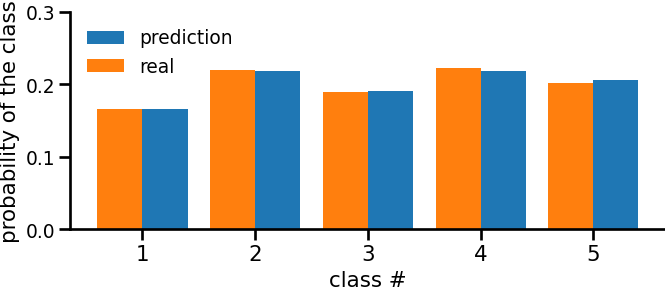

In [46]:
unique, freq = np.unique(test_labels, return_counts=True)
freq = list(map(lambda x: x / len(test_labels),freq))

pred_freq = pred_prob_test.mean(axis=0)
plt.figure()
plt.bar(range(1, 6), pred_freq, width=0.4, align="edge", label='prediction')
plt.bar(range(1, 6), freq, width=-0.4, align="edge", label='real')
plt.ylim(0, 0.3)
plt.ylabel('probability of the class')
plt.xlabel('class #')
plt.legend()
plt.show()

In [169]:
predictions=[]
# as KNN returns an array of probalities os each class 
# we need to transform them into predicted classes
for q in range(len(pred_prob)):
  predictions.append(((np.argmax(pred_prob[q])+1),spike_samp[q]))
  
print(predictions)
print(len(predictions))

[(2, 135), (5, 839), (4, 847), (3, 853), (4, 1147), (3, 1152), (3, 1294), (2, 1303), (3, 2522), (2, 2529), (5, 2753), (5, 2762), (4, 2766), (3, 2773), (3, 3071), (2, 3361), (5, 3490), (5, 3496), (2, 3502), (3, 3505), (3, 3671), (4, 3675), (4, 3814), (4, 3825), (3, 3830), (3, 3883), (2, 3887), (3, 4508), (2, 4560), (5, 4876), (3, 4885), (4, 5495), (4, 5510), (5, 6187), (5, 6192), (3, 6201), (5, 7036), (5, 7040), (4, 7049), (4, 7314), (4, 7320), (3, 8646), (2, 8654), (5, 9442), (5, 9449), (4, 9454), (3, 9470), (3, 10267), (2, 10277), (2, 10281), (4, 10472), (4, 10476), (3, 10646), (2, 10651), (2, 11118), (3, 11271), (3, 11275), (2, 11280), (4, 11683), (4, 11687), (4, 11693), (3, 12067), (2, 12072), (4, 12276), (2, 12812), (5, 14116), (3, 14125), (4, 16081), (4, 16088), (4, 16094), (3, 16589), (2, 16598), (2, 16686), (4, 16916), (2, 16923), (4, 17387), (4, 17397), (4, 17411), (5, 18979), (4, 18988), (4, 19030), (2, 19034), (4, 19566), (2, 19578), (3, 20352), (4, 20357), (4, 20369), (3, 20

In [164]:
from scipy.sparse import data
import csv
with open(data_path+'13570.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    for u in predictions:
      writer.writerow(u)
f.close



<function TextIOWrapper.close>

In [1]:
pred_freq = pred_prob.mean(axis=0)
plt.figure()
plt.bar(range(1, 6), pred_freq, width=0.4, align="edge", label='prediction')
plt.ylim(0, 0.5)
plt.legend()
plt.title('Frequency of spikes for each type')
plt.show()

NameError: ignored